In [9]:
import hdf5storage
import rat.helpers as helpers
import rat.get_data as get_data
import numpy as np
from bat.helpers_bat import *
from bat.get_data import *


%load_ext autoreload
%autoreload 2
lfp_mat = hdf5storage.loadmat('./bat/data/ephys/32622_231007_lfp.mat')
data_path = './bat/data' # Replace this
bat_id = '32622'
date =  '231007'
session = FlightRoomSession(data_path, bat_id, date, use_cache = True) # use_cache = True to save time on future loads

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading Flight Room | 32622 | 231007 from cache...


In [10]:
pos = session.cortex_data.bat_pos
cleaned_pos = np.copy(pos)
# still position on walls are nans (dont interpolate large gaps of nans)
cleaned_pos[:, 0] = interpolate_nans(pos[:, 0])
cleaned_pos[:, 1] = interpolate_nans(pos[:, 1])
cleaned_pos[:, 2] = interpolate_nans(pos[:, 2])
cleaned_pos.shape

(841160, 3)

In [22]:
from scipy.signal import decimate
lfp_timestamps = lfp_mat['global_sample_timestamps_usec'] #global timestamps in microseconds
lfp_timestamps_dec = decimate(lfp_timestamps.flatten(), 10) #decimate from 2500 Hz to 250 Hz

lfp_indices = lfp_timestamps_dec > 0 # lop off negative timestamps on LFP timestamps; we will use this to refit the LFP data later.

lfp_timestamps_dec = lfp_timestamps_dec[lfp_indices] 
lfp_timestamps_edges = np.insert(lfp_timestamps_dec, 0, 0) # insert 0 at the beginning

lfp_timestamps_edges.shape
#lfp_timestamps_edges[0:10]

(1706894,)

In [12]:
pos_timestamps = session.cortex_data.cortex_global_sample_timestamps_sec * 1e6 #converting to microseconds (usec)
valid_indices = pos_timestamps > 0 #we can use this to get rid of negative timestamps on anything position related

pos_timestamps = pos_timestamps[valid_indices] # lop off negative timestamps 
cleaned_pos = cleaned_pos[valid_indices] # lop off the corresponding positions

In [13]:
# Bin positional data using the provided label_timebins function
binned_pos_x = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 0], pos_timestamps, is_discrete=False)
binned_pos_y = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 1], pos_timestamps, is_discrete=False)
binned_pos_z = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 2], pos_timestamps, is_discrete=False)

# Construct the array according to its columns
binned_pos = np.column_stack((binned_pos_x, binned_pos_y, binned_pos_z))

In [14]:
from rat.get_data import get_LFP_from_mat

lfp_data_1 = lfp_mat['lfp'][0, 0]
lfp_data_2 = lfp_mat['lfp'][0, 1]
n_channels = lfp_data_1.shape[0] #same # of channels for lfp_data_1 and lfp_data_2 (change if not the case)

# bat LFP data sampled at 2500 Hz
lfp_bat_1 = get_LFP_from_mat(lfp_data_1,n_channels,2500,fs=250, use_cache=True) 
lfp_bat_2 = get_LFP_from_mat(lfp_data_2,n_channels,2500,fs=250, use_cache=True)

test_LFP = np.concatenate((lfp_bat_1, lfp_bat_2), axis=1) 

In [25]:
#test_LFP = test_LFP[lfp_indices]
test_LFP.shape

#lfp_timestamps_edges.shape

(1706893, 384)

In [27]:
from bat.get_data import get_flightLFP

#def get_flightLFP(session, LFPs, valid_indices, lfp_timestamps_decimated_bins, pos_timestamps):
tLFP = get_flightLFP(session, test_LFP, valid_indices, lfp_timestamps_edges, pos_timestamps)

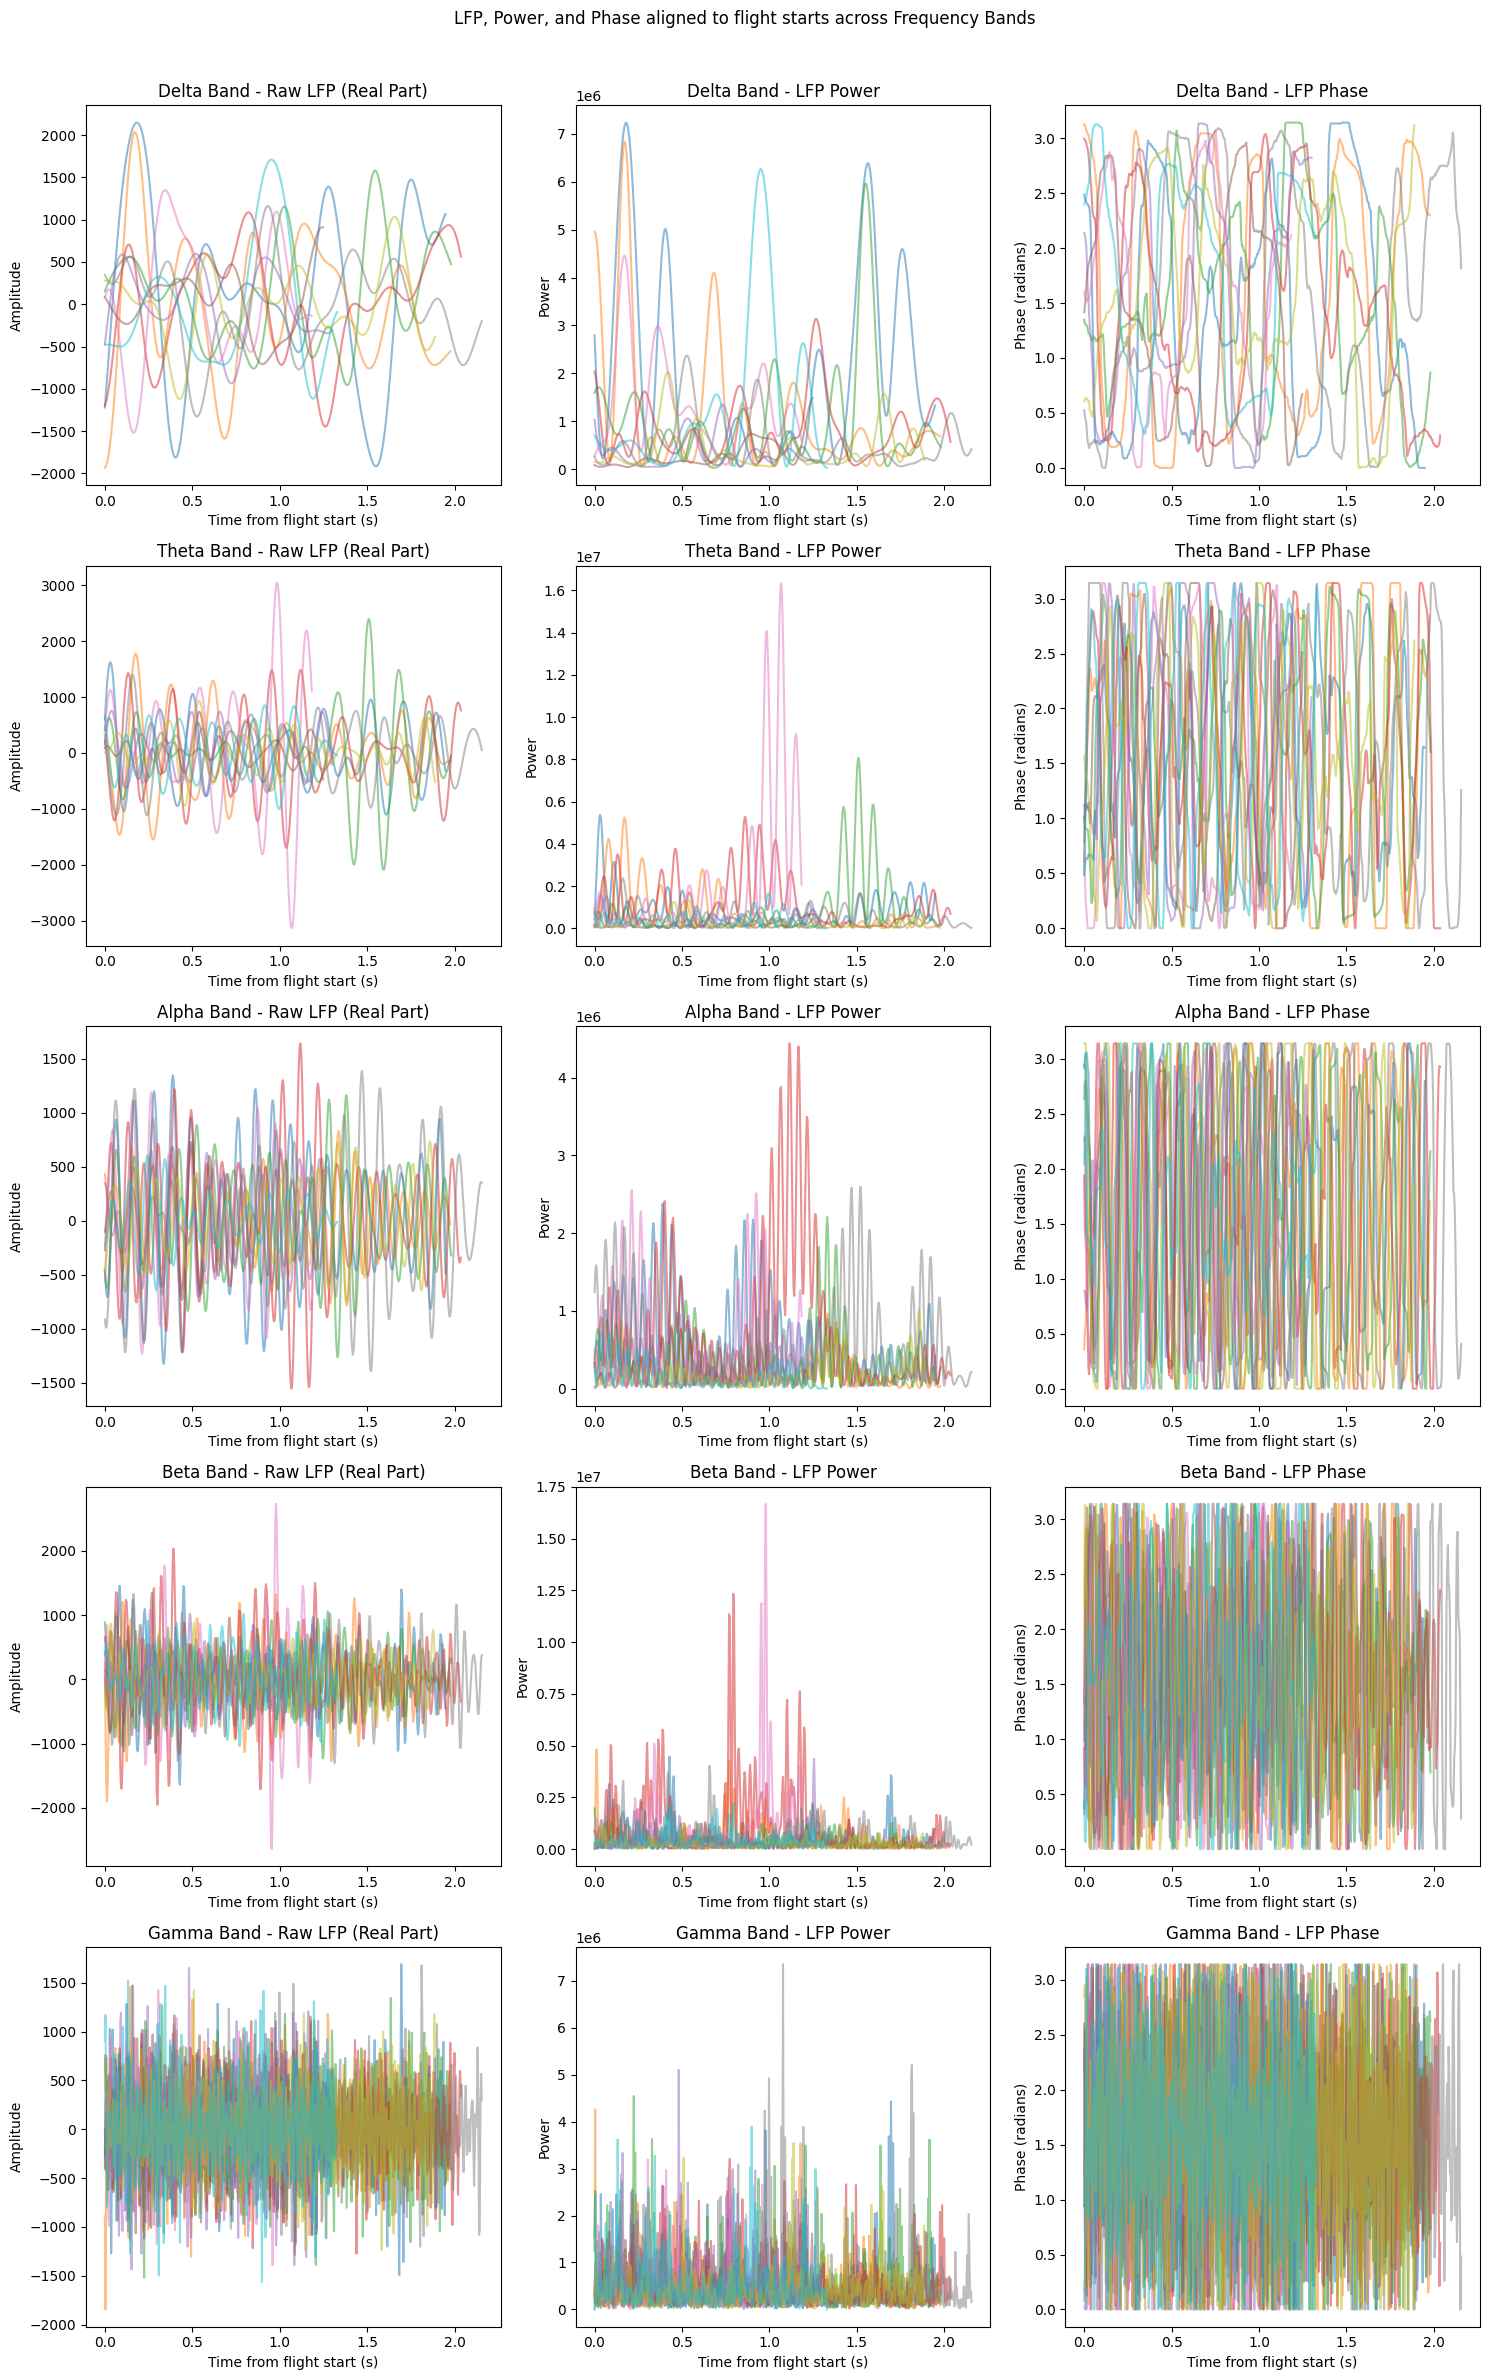

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    if low >= 1 or high >= 1 or low <= 0 or high <= 0:
        raise ValueError(f"Invalid cutoff frequencies: low={lowcut}, high={highcut} with nyquist={nyquist}")
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

def plot_lfp_alignment_by_band(tLFP, sampling_rate=250, n_flights_to_plot=10):
    """
    Generate plots to check alignment between filtered LFP data and flight trials across different frequency bands.
    
    Parameters:
    - tLFP: Array containing flight number and LFP data (output from get_flightLFP)
    - sampling_rate: Sampling rate of the LFP data (default 250 Hz)
    - n_flights_to_plot: Number of flights to plot (default 10)
    
    Returns:
    - None (displays plots)
    """
    num_flights = int(np.max(tLFP[:, 0]))
    flights_to_plot = np.linspace(0, num_flights-1, n_flights_to_plot, dtype=int)
    
    # Define frequency bands (adjusted to be within valid range)
    frequency_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 80),
        #'High Gamma': (80, 150),  # Excluded because it exceeds Nyquist frequency
        #'Ripples': (150, 250)     # Excluded because it exceeds Nyquist frequency
    }
    
    fig, axes = plt.subplots(len(frequency_bands), 3, figsize=(15, 5 * len(frequency_bands)))
    
    for band_idx, (band_name, (lowcut, highcut)) in enumerate(frequency_bands.items()):
        # Filter LFP data for the current band
        filtered_data = bandpass_filter(tLFP[:, 1:], lowcut, highcut, sampling_rate)
        
        # Plot raw LFP, power, and phase for each flight
        for flight_idx in flights_to_plot:
            flight_data = filtered_data[tLFP[:, 0] == flight_idx+1]
            
            if len(flight_data) == 0:
                continue
            
            flight_duration = len(flight_data) / sampling_rate
            flight_time_bins = np.linspace(0, flight_duration, len(flight_data))
            
            # Plot raw LFP (mean across channels, real part)
            axes[band_idx, 0].plot(flight_time_bins, np.mean(np.real(flight_data), axis=1), alpha=0.5, label=f'Flight {flight_idx+1}')
            
            # Calculate and plot power
            power = np.abs(flight_data)**2
            axes[band_idx, 1].plot(flight_time_bins, np.mean(power, axis=1), alpha=0.5, label=f'Flight {flight_idx+1}')
            
            # Calculate and plot phase
            phase = np.angle(flight_data)
            axes[band_idx, 2].plot(flight_time_bins, np.mean(phase, axis=1), alpha=0.5, label=f'Flight {flight_idx+1}')
        
        axes[band_idx, 0].set_title(f'{band_name} Band - Raw LFP (Real Part)')
        axes[band_idx, 0].set_xlabel('Time from flight start (s)')
        axes[band_idx, 0].set_ylabel('Amplitude')
        
        axes[band_idx, 1].set_title(f'{band_name} Band - LFP Power')
        axes[band_idx, 1].set_xlabel('Time from flight start (s)')
        axes[band_idx, 1].set_ylabel('Power')
        
        axes[band_idx, 2].set_title(f'{band_name} Band - LFP Phase')
        axes[band_idx, 2].set_xlabel('Time from flight start (s)')
        axes[band_idx, 2].set_ylabel('Phase (radians)')
    
    plt.suptitle('LFP, Power, and Phase aligned to flight starts across Frequency Bands')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Example usage (replace tLFP with your actual data)
plot_lfp_alignment_by_band(tLFP, sampling_rate=250, n_flights_to_plot=10)
